# Plane Fit

Common methods to find the [plane equation](https://en.wikipedia.org/wiki/Plane_(geometry) given a set of 3D points.

## Plane description

We are going to use the *point-normal* form where we have a point on the plane and the normal vector which is orthogonal to the plane:  $\mathbf{n}\cdot\left(\mathbf{r}-\mathbf{r}_0\right)=0$

$\mathbf{r}_0$ is a vector from the origin to some point on the plane $P_0=(x_0, y_0, z_0)$  ,  $\mathbf{n}=(a,b,c)$ some nonzero vector and $\mathbf{r}$ is a vector from the origin to some point $P$ on the plane. This  defines the plane as all the points $\mathbf{r}$ which satisfy thie equation.

Exapnding this vector equation will give us:
$a\left(x-x_0\right)+b\left(y-y_0\right)+c\left(z-z_0\right)=0$

Which is the simple *point-normal* form: $ax+by+cz+d=0$  with  $d=-(ax_0+by_0+cz_0)$

## Generating some data

First we just do some basic imports and initialize some 3D points using a normal unit vector $\mathbf{\hat{n}}=(\frac{1}{\sqrt{2}}, \frac{1}{2}, -\frac{1}{2})$. `data` is $N\times3$ matrix, where $N$ is the number of points and the 3 columns are $x, y, z$. We also create some noisy data by adding normal distributed noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
%matplotlib inline
#%matplotlib notebook

In [2]:
# Generating test data
P0 = np.array([0.0, 0.0, 0.0])
a, b, c, d = 0.707, 0.5, -0.5, 2
X = (np.random.random(100) - 0.5) * 2
Y = (np.random.random(100) - 0.5) * 2
Z = (a*X + b*Y + d) / (-c)
data = np.vstack((X, Y, Z)).T 
data += np.random.normal(0, 0.2, data.shape)

## Ordinary Least Squares
The first method we are going to use is [linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares_(mathematics). Here we are going to represent our plane equation as: $z = ax + by + d$, by setting $c=-1$ and we want to find the best parameters $a, b$ and $d$ given our points. Of course, for any number of points larger than 3 this is an [overdetermined system](https://en.wikipedia.org/wiki/Overdetermined_system) of equations and the least squares method will find the best parameters which minimizes the sum of squared differences between our points and the plane.

Keep in mind that here we are **only minimizing the z-distance error**, assuming x and y values are fixed.

The matrix notation we are using is:  $\mathbf{Ax}=\mathbf{b}$  , where $\mathbf{A}_{N\times 3}=\left[ \begin{array}{ccc}
x_0 & y_0 & 1 \\
x_1 & y_1 & 1 \\
\vdots & \vdots & \vdots \\
x_N & y_N & 1 \end{array} \right]$ ,  $\mathbf{x}_{3\times 1}=\left[a, b, d\right]^T$  and  $\mathbf{b}_{N\times 1}=\left[\ \begin{array}{c} z_0 \\ z_1 \\ \vdots \\ z_N \end{array} \right]$

### Remarks
- Notice that $\mathbf{x}$ here just represents our unknown, which is the parameters $(a,b,d)$. Nothing to do with the x-axis.
- Common mistake is to represent our problem as homegenous using the standard equation: $ax+by+cz+d=0$ with
$\mathbf{A}_{N\times 4}=\left[ \begin{array}{cccc}
x_0 & y_0 & z_0 & 1 \\
x_1 & y_1 & z_1 & 1 \\
\vdots & \vdots & \vdots & \vdots \\
x_N & y_N & z_N & 1 \end{array} \right]$ ,  $\mathbf{x}_{4\times 1}=\left[a, b, c, d\right]^T$  and  $\mathbf{b}_{N\times 1}=\mathbf{0}$ .  In this case the least-squares would have just given us the trivial solution where $\mathbf{x}=\mathbf{0}$

In [3]:
# Least-squares
A = np.vstack((data[:,0], data[:,1], np.ones(data.shape[0]))).T
C,_,_,_ = np.linalg.lstsq(A, data[:,2])    # coefficients
print("Estimated coefficients (Least-squares):", end="")
print("a=%.3f, b=%.3f, c=-1, d=%.3f" % tuple(C))

# regular grid covering the domain of the data
XX, YY = np.meshgrid(np.arange(-2, 2, 0.5), np.arange(-2, 2, 0.5))

# evaluate it on grid
ZZ = C[0]*XX + C[1]*YY + C[2]

# Get the normal unit vector
n = np.array([C[0], C[1], -1.0])
n /= np.linalg.norm(n)
print("n_hat=(%.3f, %.3f, %.3f)" % tuple(n))

# Get point on the plane
i = int(XX.shape[0] / 2)
p0 = np.array([XX[i, i], YY[i, i], ZZ[i, i]])

Estimated coefficients (Least-squares):a=1.226, b=0.961, c=-1, d=3.979
n_hat=(0.662, 0.519, -0.540)


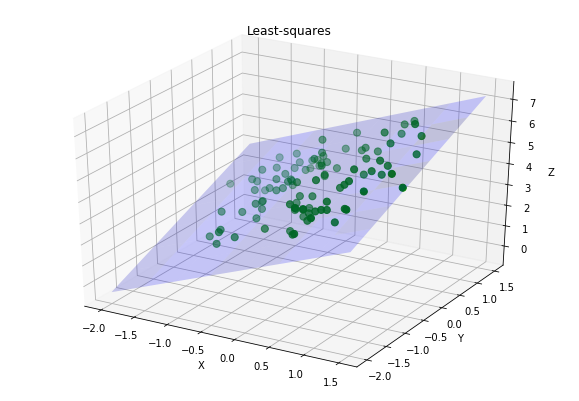

In [4]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, alpha=0.2, color='blue')
ax.scatter(data[:,0], data[:,1], data[:,2], color='green', s=50)
#ax.plot([p0[0], p0[0]+n[0]], [p0[1], p0[1]+n[1]], [p0[2], p0[2]+n[2]], color='blue', marker='.')
# ax.quiver(p0[0], p0[1], p0[2], -n[0], -n[1], -n[2], length=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Least-squares")
ax.axis('equal')
ax.axis('tight');

## Random sample consensus (RANSAC)
[RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus) is an iterative method to estimate parameters of a mathematical model from a set of observed data that **contains outliers**. We will use the same problem definition as before, where we minimize the error of the points along the z-axis only. Notice that now some of the points will be marked as outliers, and the plane estimation won't use them. Of course this method is designed for much noiser data than this example.

### Remarks
- RANSAC can also be used to find multiple planes. We can run it iteratively on all the points, each time we find a single plane and remove the points which lie on this plane from the data. 

In [5]:
from sklearn import linear_model

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(fit_intercept=False))
model_ransac.fit(A, data[:, 2])
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
print("Estimated coefficients (RANSAC):", end="")
print("a=%.3f, b=%.3f, c=-1, d=%.3f" % tuple(model_ransac.estimator_.coef_))

# Evaluate on grid
ZZ = C[0]*XX + C[1]*YY + C[2]

Estimated coefficients (RANSAC):a=1.220, b=0.863, c=-1, d=4.009


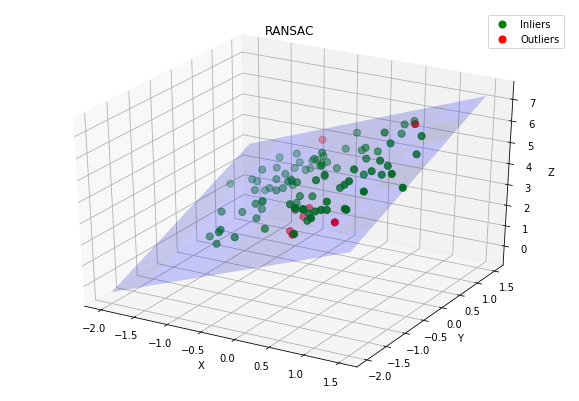

In [6]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, alpha=0.2, color='blue')
ax.scatter(data[inlier_mask, 0], data[inlier_mask, 1], data[inlier_mask, 2], color='green', s=50, label='Inliers')
ax.scatter(data[outlier_mask, 0], data[outlier_mask, 1], data[outlier_mask, 2], color='red', s=50, label='Outliers')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("RANSAC")
ax.legend()
ax.axis('equal')
ax.axis('tight');

## Singular Value Decomposition (SVD)

Unlike the least-squares method where we only minimized the z-distance error, here we are going to minimize the **orthogonal distance** (also called *total leaset-squares*). This is the correct method to use when we have a measurment error in all axes.

Starting with the distance from a point to a plane, we wish to find 
$a$, $b$, $c$ and $d$ such that we minimize

\begin{equation*}
f(a,b,c,d) = \sum{\frac{ \| ax_i + by_i + cz_i + d\|^2}{a^2 + b^2 + c^2}}
\end{equation*}
  
If we set the partial derivative with respect to d equal to zero, we can solve for d to get

\begin{equation*}
d = -(ax_0 + by_0 + cz_0)
\end{equation*}

where $(x_0, y_0, z_0)$ is the centroid of the data. This means that the least squares plane contains the centroid. If we substitute it back into the equation for the plane we get

\begin{equation*}
a(x - x_0) + b(y - y_0) + c(z - z_0) = 0
\end{equation*}

We can rewrite $f(a,b,c,d)$ like this

\begin{equation*}
f(a,b,c) = \sum{ \frac{ \|a(x_i-x_0) + b(y_i-y_0) + c(z_i-z_0)\|^2 }{a^2+b^2+c^2}  }
\end{equation*}

Let's define $\mathbf{v}$ and $\mathbf{M}$ such that

\begin{equation*}
\mathbf{v}^T = \left[a, b, c \right]
\end{equation*}

\begin{equation*}
\mathbf{M} = \left[ \begin{array}{ccc}
x_1 - x_0 & y_1 - y_0 & z_1 - z_0 \\
x_2 - x_0 & y_2 - y_0 & z_2 - z_0 \\
\vdots & \vdots & \vdots \\
x_N - x_0 & y_N - y_0 & z_N - z_0 \end{array} \right]
\end{equation*}


If you multiply the matrices out, you will see that $f(a,b,c)$ becomes

\begin{equation*}
f(\mathbf{v}) = \frac{ ( \mathbf{v}^T\mathbf{M}^T)(\mathbf{Mv})}{\mathbf{v}^T\mathbf{v}} =
\frac{\mathbf{v}^T (\mathbf{M}^T\mathbf{M})\mathbf{v}}{\mathbf{v}^T\mathbf{v}}
\end{equation*}

Let's define $\mathbf{A} = \mathbf{M}^T \mathbf{M}$, which when divided by the number of data points 
becomes the covariance matrix of the data.

$f(\mathbf{v})$ is called a Rayleigh Quotient. It is minimized by the eigenvector of $\mathbf{A}$ that corresponds to its smallest eigenvalue.

We could compute the eigenvectors of \mathbf{A}, but this is not needed. The SVD of \mathbf{M} is

\begin{equation*}
\mathbf{M} = \mathbf{U}\mathbf{S}\mathbf{V}^T
\end{equation*}

where $\mathbf{S}$ is a diagonal matrix containing the singular values of $\mathbf{M}$, the 
columns of $\mathbf{V}$ are its singular vectors, and $\mathbf{U}$ is an orthogonal matrix.

Now

\begin{equation*}
\mathbf{A} = \mathbf{M}^T\mathbf{M}= \left( \mathbf{U}\mathbf{S}\mathbf{V}^T \right)^T \left( \mathbf{U}\mathbf{S}\mathbf{V}^T \right) = \left( \mathbf{V}\mathbf{S}^T\mathbf{U}^T \right) \left( \mathbf{U}\mathbf{S}\mathbf{V}^T \right) = \mathbf{V}\mathbf{S}^2\mathbf{V}^T
\end{equation*}

This decomposition of $\mathbf{A}$ diagonalizes the matrix and provides an eigenvector decomposition. It means that the eigenvalues of $\mathbf{A}$ are the squares of the singular values of $\mathbf{M}$, and the eigenvectors of $\mathbf{A}$ are the singular vectors of $\mathbf{M}$.

To conclude, the orthogonal least squares 3D plane contains the centroid of the data, and its normal vector is the singular vector of $\mathbf{M}$ corresponding to its smallest singular value.


In [7]:
# Set up constraint equations of the form  Ax = 0,
# where x is a column vector of the plane coefficients
# in the form x[0]*X + x[1]*Y +x[2]*Z = 0.
centeroid = data.mean(axis=0)
M = data - centeroid
[u, s, vh] = np.linalg.svd(M)

# The last column of the V matrix (last row of Vh matrix) indicate the eigenvectors of
# smallest eigenvalues (singular values).
v = vh.conj().transpose()  
n = v[:,-1]

# Set c=-1
n /= -n[2]

# Compute d
d = -centeroid.dot(n)

print("Estimated coefficients (SVD):", end="")
print("a=%.3f, b=%.3f, c=%.3f, d=%.3f" % tuple(n.tolist() + [d]))

# Evaluate on grid
ZZ = n[0]*XX + n[1]*YY + d

Estimated coefficients (SVD):a=1.366, b=1.088, c=-1.000, d=4.003


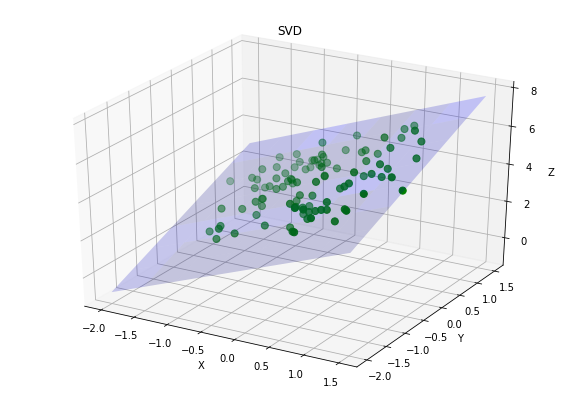

In [8]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, alpha=0.2, color='blue')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], color='green', s=50)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("SVD")
ax.axis('equal')
ax.axis('tight');